In [6]:
import os
import json
import cv2
import matplotlib.pylab as plt

In [19]:
import seaborn as sns
import numpy as np
from matplotlib.patches import Polygon
from PIL import Image
from matplotlib.collections import PatchCollection

In [8]:
from structures.segmentation_mask import SegmentationMask

In [28]:
from pycocotools.coco import COCO

In [2]:
data = json.load(open("/data2/lzy/pathology/cocojson.json","r"))

In [3]:
data["images"][0]

{'file_name': '74b0819e7bdf11eabdd4000c29e37e62.jpg',
 'width': 4912,
 'id': 0,
 'height': 3684}

In [13]:
a = np.eye(20)
b = cv2.resize(a,(10,10), interpolation=cv2.INTER_NEAREST)

In [15]:
c = cv2.imread("/data2/lzy/pathology/train2017/74b0819e7bdf11eabdd4000c29e37e62.jpg")

In [21]:
cc = Image.fromarray(np.eye(20))

In [24]:
np.array(cc).shape

(20, 20)

In [4]:
for i,r in data.items():
    print(i)

images
annotations
categories


In [77]:
data["categories"]

[{'supercategory': '0', 'id': 0, 'name': '0'},
 {'supercategory': '1', 'id': 1, 'name': '1'},
 {'supercategory': '2', 'id': 2, 'name': '2'},
 {'supercategory': '3', 'id': 3, 'name': '3'},
 {'supercategory': '4', 'id': 4, 'name': '4'},
 {'supercategory': '5', 'id': 5, 'name': '5'},
 {'supercategory': '6', 'id': 6, 'name': '6'}]

# 1

In [35]:
coco = COCO("/data2/lzy/pathology/cocojson.json")

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


In [89]:
coco.loadImgs(0)[0]

{'file_name': '74b0819e7bdf11eabdd4000c29e37e62.jpg',
 'width': 4912,
 'id': 0,
 'height': 3684}

In [81]:
a = [ j  for cid in coco.getCatIds() for j in coco.catToImgs[cid] ]

In [84]:
len(set(a).tolist())

AttributeError: 'set' object has no attribute 'tolist'

In [39]:
ids = coco.getCatIds(['0'])[0]
imgIds = coco.catToImgs[ids]
imgId = imgIds[288]
imgInfo = coco.loadImgs(imgId)[0]
annIds = coco.getAnnIds(imgIds=imgInfo['id'])
anns = coco.loadAnns(annIds)

In [90]:
imgInfo['id']

687

In [66]:
anns = [data["annotations"][0],data["annotations"][1] ]

In [71]:
cate_num = 4
m = [[] for c in range(cate_num)]
for ann in anns:
    cid = ann["category_id"]
    m[cid].append(c.annToMask(ann))
m2 = [np.max(np.array(a),0) if len(a) > 1 else np.array(a) for a in m ]

In [76]:
m2

[array([], dtype=float64), array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8), array([], dtype=float64), array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)]

(3684, 4912)

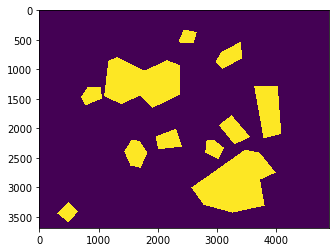

In [47]:
m[0].shape

(3684, 4912)

# 2

In [22]:
anns = [data["annotations"][0]]
cp = sns.color_palette("bright",9)
polygons = []
color = []
for ann in anns:
    c = list(cp[ann["category_id"]])
    if 'segmentation' in ann:
        if type(ann['segmentation']) == list:
            # polygon
            for seg in ann['segmentation']:
                poly = np.array(seg).reshape((int(len(seg) / 2), 2))
                polygons.append(Polygon(poly))
                color.append(c)
p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)


# 3

In [22]:
anns = [data["annotations"][0],data["annotations"][1]]
masks = [obj["segmentation"] for obj in anns]
size = (4912,3684)
masks = SegmentationMask(masks, size, mode='poly')

In [23]:
m = masks.get_mask_tensor()
print(m.shape)

torch.Size([2, 3684, 4912])


TypeError: Invalid shape (2, 3684, 4912) for image data

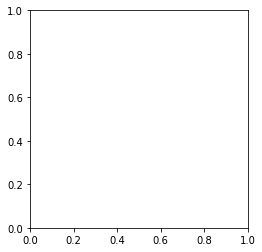

In [24]:

plt.imshow(np.array(m))

In [15]:
masks.instances 

PolygonList(num_instances=1, image_width=4912, image_height=3684)

In [25]:
def polygons_to_mask(polygons):

    mask = np.zeros((4912,3684), dtype=np.uint8)
    mask = PIL.Image.fromarray(mask)
    xy = list(map(tuple, polygons))
    PIL.ImageDraw.Draw(mask).polygon(xy=xy, outline=1, fill=1)
    mask = np.array(mask, dtype=bool)
    return mask

In [ ]:
polygons_to_mask()

In [20]:
with open("/data2/lzy/pathology/cocojson.json","r") as f :
    dt = f.read()
    dt = dt.replace("\n","")
    dt2 = json.loads(dt)
len(dt2["annotations"])

6975

In [21]:
tmp_path = "/data2/lzy/pathology/cocojson_13.json"

In [22]:
# 非肿瘤：0 轻度异形：1

In [23]:
# 筛选1 和 3
images = dt2["images"]
annotations = dt2["annotations"]
images2 = []
annotations2 = []

an_id = 0
img_id_list = [] #存下1和3的image id
for i in range(len(annotations)):
    tmp_a = annotations[i]
    if tmp_a["category_id"] == 1:
        tmp_a["id"] = an_id
        an_id += 1
        annotations2.append(tmp_a)
        img_id_list.append(tmp_a["image_id"])
    if tmp_a["category_id"] == 3:
        tmp_a["id"] = an_id
        tmp_a["category_id"] = 0
        an_id += 1
        annotations2.append(tmp_a)
        img_id_list.append(tmp_a["image_id"])

img_id = 0
img_id_list = list(set(img_id_list))
for i in img_id_list:
    tmp_i = images[i]
    origin_id = tmp_i["id"]
    tmp_i["id"] = img_id
    
    for i in range(len(annotations2)):
        if annotations2[i]["image_id"] == origin_id:
            annotations2[i]["image_id"] = img_id
    
    img_id += 1
    images2.append(tmp_i)
    
cate2 = dt2["categories"][:2]

dt3 = {}
dt3["images"] = images2
dt3["annotations"] = annotations2
dt3["categories"] = cate2

with open(tmp_path,"w") as f :
    json.dump(dt3,f,ensure_ascii=False)
    

In [24]:
len(dt3["images"])

3344

In [26]:
len(dt3["annotations"])

4513

# train val split

In [75]:
with open("/data2/lzy/pathology/cocojson_13.json","r") as f :
    dt = f.read()
    dt = dt.replace("\n","")
    dt2 = json.loads(dt)
len(dt2["annotations"])

4513

In [76]:
tmp_path = "/data2/lzy/pathology/cocojson_13_val_4.json"

In [27]:
# 836 1672 2508

In [31]:
# val

In [58]:
ls = []
for i in range(0,836):
    ls.append(i)

In [64]:
ls = []
for i in range(836,1672):
    ls.append(i)

In [71]:
ls = []
for i in range(1672,2508):
    ls.append(i)

In [77]:
ls = []
for i in range(2508,3344):
    ls.append(i)

In [32]:
# train

In [33]:
ls = []
for i in range(836,3344):
    ls.append(i)

In [39]:
ls = []
for i in range(0,836):
    ls.append(i)
for i in range(1672,3344):
    ls.append(i)

In [46]:
ls = []
for i in range(0,1672):
    ls.append(i)
for i in range(2508,3344):
    ls.append(i)

In [52]:
ls = []
for i in range(0,2508):
    ls.append(i)

In [78]:
images = dt2["images"]
annotations = dt2["annotations"]
images2 = []
annotations2 = []

#  images 重新排序 0 -> n
c_an = 0
c_img = 0
origin_img_id = []
for i in ls:
    tmp_i = images[i]
    origin_img_id.append(tmp_i['id'])
    tmp_i['id'] = c_img
    images2.append(images[i])
    c_img += 1

# annotations 
for i in range(len(annotations)):
    tmp_a = annotations[i]
    if tmp_a["category_id"] <2:
        for j in range(len(origin_img_id)):
            if tmp_a['image_id'] == origin_img_id[j]:
                tmp_a['image_id'] = j
                tmp_a['id'] =  c_an
                c_an += 1
                annotations2.append(tmp_a)
                break
    
    
    
    
print(len(images2))
print(len(annotations2))

836
1112


In [79]:
dt3 = {}
dt3["images"] = images2
dt3["annotations"] = annotations2
dt3["categories"] = dt2["categories"]

In [80]:
with open(tmp_path,"w") as f :
    json.dump(dt3,f,ensure_ascii=False)